# Compare different sequential models

Author: Thorsten Kalb

This Notebook should execute the functions given in movielens_sequence and evaluate the validation accuracy.
It will be used later to compare the sequential models to the explicit model.

In [1]:
from spotlight.cross_validation import user_based_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel
import matplotlib.pyplot as plt
import numpy as np

dataset = get_movielens_dataset('1M')

Mean mrr validation score: 0.0392 for model pooling
On average, the first relevant movie int the predicted sequence is at place 283.4075370806544 for model pooling
Mean mrr validation score: 0.0428 for model cnn
On average, the first relevant movie int the predicted sequence is at place 327.51788783499904 for model cnn
Mean mrr validation score: 0.0137 for model lstm
On average, the first relevant movie int the predicted sequence is at place 687.3515182379527 for model lstm


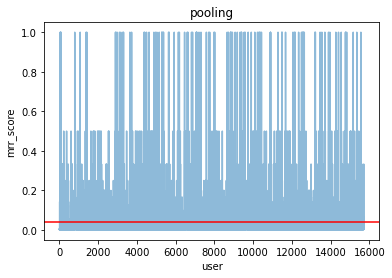

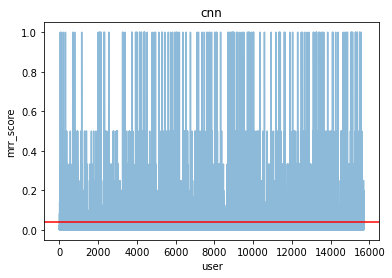

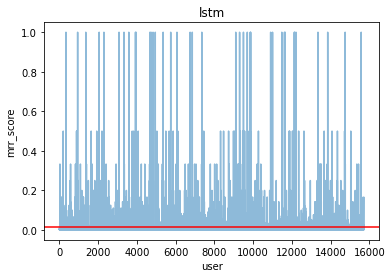

In [2]:
train, test = user_based_train_test_split(dataset)

train, validation = user_based_train_test_split(train)

train = train.to_sequence()
validation = validation.to_sequence()
test = test.to_sequence()

sequmods = ['pooling','cnn','lstm']

for repres in sequmods:
    
    model = ImplicitSequenceModel(n_iter=10, #10 #5 #3 #50
                              representation=repres,
                              loss='bpr')
    model.fit(train)
    mrr = sequence_mrr_score(model, validation)
    fig = plt.figure()
    mean_mrr = np.mean(mrr)
    mean_invmrr = np.mean(1/mrr[mrr>0.0])
    plt.plot(mrr,alpha=0.5)
    #plt.yscale('log')
    plt.title(repres)
    plt.xlabel("user")
    plt.ylabel("mrr_score")
    plt.axhline(y=mean_mrr, color='r', linestyle='-')
    print("Mean mrr validation score: {:.4f} for model {}".format(mean_mrr,repres))
    print("On average, the first relevant movie int the predicted sequence is at place {} for model {}".format(mean_invmrr,repres))



## Result:

It depends a lot on the **number of epochs** during training, which model performs better. However, for few iterations, the CNN and lstm have an average mrr score of 0.2m while the pooling model has an average mrr score of 0.4. For more epochs, the validation mrr score increases for all models. 

For 50 epochs, I report a mrr scores of 0.058, 0.056 and 0.023 for the pooling, cnn and lstm models, respectively. 
For 100 epochs, I report mrr scores of 0.055, 0.043 and 0.045 for the pooling, cnn and lstm models, respectively.
For a better comparison, these experiments should be saved in a docker image with fixed seed etc. 

I propose **new metrics** for the evaluation here, namely, when does the **first relevant movie** appear in the list, on average. Therefore, I take the average over users of all the inverses of the mrr_scores, wherever the inverse exists.

Thus, I would **choose the Pooling model**. The advantage is a higher starting mrr score and a consistently higher mrr score, which means we do not need to train the model a lot and thus, it is quickly accesible and highly adaptable to new data.

A **direct comparison with the Explicit model is not (yet) possible**. This is, because of the different nature of the models: Sequential models try to predict the next element of a sequence, whereas the explicit model tries to predict the rating of the user on a movie that the user has not yet seen. Perhaps in the future, we can work on a way to compare the models, e.g. by ordering the rankings from the explicit model and turning this into a sequence?

Interestingly, the **mrr scores change for bigger datasets**, resulting in CNN outperforming the pooling, for the given 50 training epochs and evaluating the mean of the mrr score. Interestingly, the mean place, with the first relevant movie is still better for the pooling model for the 1M dataset. The LSTM model worsens in both aspects significantly for the 1M dataset.
